## Imports

In [54]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras import layers
from matplotlib import pyplot as plt

os.environ['KMP_DUPLICATE_LIB_OK']='True'
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [55]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

## Normalization

In [56]:
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
6202,0.659351,-0.765075,-0.046823,-1.069597,-1.068592,-0.811580,-1.077242,-0.771885,-0.956176
12930,-1.131024,0.456069,0.112072,0.047862,-0.088757,0.053514,0.087845,0.242968,-0.192276
16530,-1.544955,1.335667,-0.602955,-0.264990,-0.347357,-0.444808,-0.276245,-0.323128,-0.268149
13473,-1.190870,0.755507,0.270967,-0.578759,-0.712719,-0.631243,-0.650737,1.159298,1.707990
3138,0.863823,-0.844613,-0.205717,0.282271,-0.197891,-0.065839,-0.109804,0.994741,0.519892


In [57]:
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

test_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.233523,0.814497,-0.146975,0.596319,0.315284,0.130224,0.317681,1.510494,1.227494
1,0.646236,-0.645823,1.127377,-0.505466,-0.529167,-0.576200,-0.582646,-0.112305,-0.259427
2,0.891858,-0.871210,-0.146975,0.459002,-0.055216,0.078795,0.013924,1.070971,0.571551
3,0.616160,-0.852428,-0.067328,-1.174887,-1.238892,-1.313675,-1.310570,1.255656,1.097543
4,-0.040503,0.326159,-0.784152,-0.630257,-0.687953,-0.536415,-0.692108,-0.469003,-1.097477


In [58]:
train_df_norm["median_house_value"].describe()

count    1.700000e+04
mean     3.220300e-17
std      1.000000e+00
min     -1.658007e+00
25%     -7.578726e-01
50%     -2.319369e-01
75%      4.974756e-01
max      2.523630e+00
Name: median_house_value, dtype: float64

## Label Binarization

In [59]:
threshold_in_Z = 1
train_df_norm["median_house_value_is_high"] = train_df_norm["median_house_value"] > threshold_in_Z
test_df_norm["median_house_value_is_high"] = test_df_norm["median_house_value"] > threshold_in_Z
train_df_norm["median_house_value_is_high"].value_counts()

False    14223
True      2777
Name: median_house_value_is_high, dtype: int64

## Feature Engineering

In [60]:
feature_cols = []
median_income = tf.feature_column.numeric_column("median_income")
feature_cols.append(median_income)

tr = tf.feature_column.numeric_column("total_rooms")
feature_cols.append(tr)

feature_layer = tf.keras.layers.DenseFeatures(feature_cols)

# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:
feature_layer(dict(train_df_norm))

<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[-0.7718854 , -1.0695968 ],
       [ 0.24296848,  0.04786152],
       [-0.32312763, -0.26499012],
       ...,
       [-0.33387098, -0.14847352],
       [-0.705591  , -0.12049118],
       [-0.8792141 , -0.58609885]], dtype=float32)>

## Modeling

In [61]:
def create_model(_learning_rate, _feature_layer, _metrics):
    _model = tf.keras.models.Sequential()
    _model.add(_feature_layer)
    _model.add(layers.Dense(units=1, input_shape=(1,), activation=tf.sigmoid))
    _model.compile(
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=_learning_rate),
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics = _metrics
    )
    return _model

def train_model(_model, _dataset, _epochs, _label_name, _batch_size, _shuffle):
    _features = {name:np.array(value) for name, value in _dataset.items() if name != _label_name}
    _labels = np.array(_dataset[_label_name])
    _history = _model.fit(
        x = _features,
        y = _labels,
        epochs = _epochs,
        batch_size = _batch_size,
        shuffle = _shuffle
    )
    _trained_epochs = _history.epoch
    _hist = pd.DataFrame(_history.history)
    return _trained_epochs, _hist

## Plotting

In [62]:
def plot_curve(_epochs, _hist, _metrics):
    plt.figure()
    plt.xlabel("Epochs")
    plt.ylabel("Value")

    for m in _metrics:
        x = _hist[m]
        plt.plot(_epochs[1:], x[1:], label=m)
    plt.legend()

## Training

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 869us/step - loss: 0.7681 - accuracy: 0.5157 - precision: 0.0522 - recall: 0.1145 - auc: 0.2033
Epoch 2/20
170/170 [==============================] - 0s 816us/step - loss: 0.6742 - accuracy: 0.7527 - precision: 0.0604 - recall: 0.0353 - auc: 0.2294
Epoch 3/20
170/170 [==============================] - 0s 981us/step - loss: 0.5940 - accuracy: 0.8169 - precision: 0.1149 - recall: 0.0180 - auc: 0.3308
Epoch 4/20
170/170 [==============================] - 0s 921us/step - loss: 0.5263 - accuracy: 0.8315 - precision: 0.2708 - recall: 0.0187 - auc: 0.6966
Epoch 5/20
170/170 [==============================] - 0s 878us/step - loss: 0.4705 - accuracy: 0.8448 - precision: 0.7518 - recall: 0.0742 - auc: 0.8112
Epoch 6/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4268 - accuracy: 0.8586 - precision: 0.9349 - rec

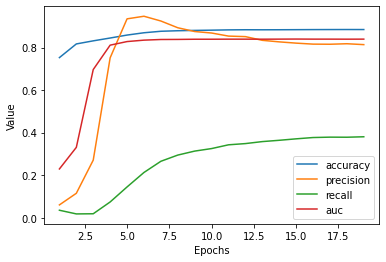

In [63]:
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.52

metrics = [
    tf.keras.metrics.BinaryAccuracy(
        name="accuracy",
        threshold=classification_threshold,
    ),
    tf.keras.metrics.Precision(
        name="precision",
        thresholds=classification_threshold,
    ),
    tf.keras.metrics.Recall(
        name="recall",
        thresholds=classification_threshold,
    ),
    tf.keras.metrics.AUC(
        num_thresholds=100, # binning of ROC curve
        name='auc',
    ),
]

model = create_model(
    _learning_rate=learning_rate,
    _feature_layer=feature_layer,
    _metrics=metrics,
)
trained_epochs, hist = train_model(
    _model=model,
    _dataset=train_df_norm,
    _epochs=epochs,
    _label_name=label_name,
    _batch_size=batch_size,
    _shuffle=True,
)

metrics_plot = ['accuracy', 'precision', 'recall', 'auc']
plot_curve(
    _epochs=trained_epochs,
    _hist=hist,
    _metrics=metrics_plot,
)

In [64]:
features = {name:np.array(value) for name, value in test_df_norm.items() if name != label_name}
labels = np.array(test_df_norm[label_name])
model.evaluate(features, labels, batch_size=batch_size)

Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 831us/step - loss: 0.3130 - accuracy: 0.8853 - precision: 0.7982 - recall: 0.3671 - auc: 0.8320


[0.31299540400505066,
 0.8853333592414856,
 0.7981651425361633,
 0.3670886158943176,
 0.8320053815841675]